This notebook decscribes how btk can be used to evaluate the performance of detection/segmentation/deblending/measuremnt algorithms.


In [1]:
import os
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
def plot_blends( blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['dx'], entry['dy'],'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

# Detection metrics



In [3]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=4)
#Load input catalog
catalog = btk.get_input_catalog.load_catlog(param)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

### Compute detection metrics for SEP (Source Extraction and Photometry in Python) in sum image
Note: This requires sep to have been installed locally.

Out of 5 galaxies: 3 detected, 2 undetected, & 0  spurious detections


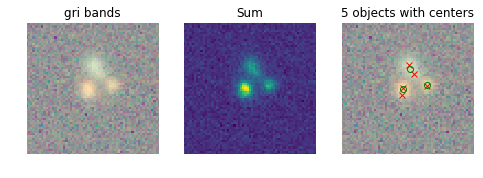

Out of 2 galaxies: 2 detected, 0 undetected, & 0  spurious detections


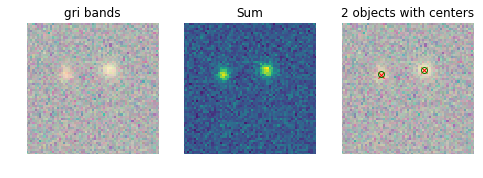

Out of 3 galaxies: 3 detected, 0 undetected, & 0  spurious detections


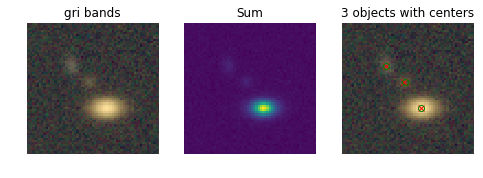

Out of 3 galaxies: 2 detected, 1 undetected, & 0  spurious detections


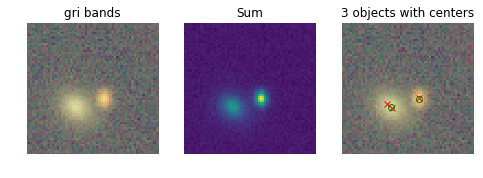

In [4]:
np.random.seed(param.seed)
meas_params = btk.utils.SEP_params()
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
output, deb, _ = next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i][1]
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    det, undet, spur = btk.compute_metrics.evaluate_detection(
        detected_centers, true_centers)
    print("Out of %i galaxies: %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

In [5]:
# Get precision and recall for 100 runs
# Precison is fraction of predictions that are correct.
# Recall is fraction of targets correctly predicted.

np.random.seed(param.seed)
meas_params = btk.utils.SEP_params()
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
results = []
for i in range(100):
    output, deb, _ = next(meas_generator)
    blend_list = output['blend_list']
    for j in range(len(blend_list)):
        detected_centers = deb[j][1]
        # Select true sources as only those galaxies drawn in atleast 1 band
        cond = np.any([blend_list[j]['not_drawn_' + b] == 0 for b in ['u', 'g', 'r', 'i' ,'z', 'y']], axis=0)
        true_centers = np.stack([blend_list[j]['dx'][cond], blend_list[j]['dy'][cond]]).T
        det, undet, spur = btk.compute_metrics.evaluate_detection(
            detected_centers, true_centers)
        results.append([len(true_centers), det, undet, spur])
all_results = np.sum(results, axis=0)
print("Out of {0} galaxies: {1} detected, {2} undetected, & {3}  spurious detections".format(*all_results))
precision = all_results[1] / (all_results[1] + all_results[3])
recall = all_results[1] / all_results[0]
print("Precision: {0:.4f}, Recall: {1:.4f}".format(precision, recall))

Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Out of 1219 galaxies: 804 detected, 415 undetected, & 0  spurious detections
Precision: 1.0000, Recall: 0.6596


### Compute detection metrics for LSST Science Pipeline in i band
Note: This requires DM stack to have been installed locally.

Out of 5 galaxies: 3 detected, 2 undetected, & 0  spurious detections


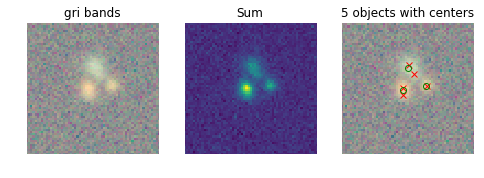

Out of 2 galaxies: 2 detected, 0 undetected, & 0  spurious detections


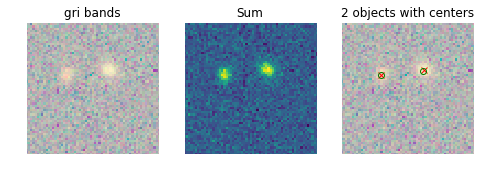

Out of 3 galaxies: 3 detected, 0 undetected, & 0  spurious detections


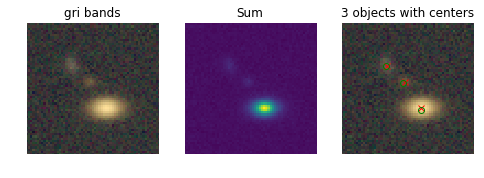

Out of 3 galaxies: 2 detected, 1 undetected, & 0  spurious detections


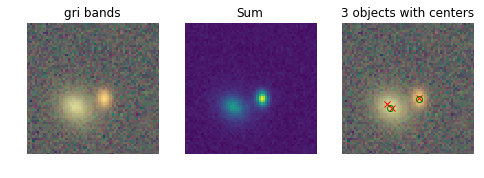

In [6]:
np.random.seed(param.seed)
meas_params = btk.utils.Stack_params()
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
output, _, cat=next(meas_generator)
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = np.stack([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']], axis=1)
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    det, undet, spur = btk.compute_metrics.evaluate_detection(
        detected_centers, true_centers)
    print("Out of %i galaxies: %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

In [9]:
# Get precision and recall for 100 runs
# Precison is fraction of predictions that are correct.
# Recall is fraction of targets correctly predicted.

np.random.seed(param.seed)
meas_params = btk.utils.Stack_params()
meas_generator = btk.measure.generate(
        meas_params, draw_blend_generator, param)
results = []
for i in range(100):
    output, _, cat=next(meas_generator)
    blend_list = output['blend_list']
    for j in range(len(blend_list)):
        detected_centers = np.stack([cat[j]['base_NaiveCentroid_x'], cat[j]['base_NaiveCentroid_y']], axis=1)
        # Select true sources as only those galaxies drawn in atleast 1 band
        cond = np.any([blend_list[j]['not_drawn_' + b] == 0 for b in ['u', 'g', 'r', 'i' ,'z', 'y']], axis=0)
        true_centers = np.stack([blend_list[j]['dx'][cond], blend_list[j]['dy'][cond]]).T
        det, undet, spur = btk.compute_metrics.evaluate_detection(
            detected_centers, true_centers)
        results.append([len(true_centers), det, undet, spur])
all_results = np.sum(results, axis=0)
print("Out of {0} galaxies: {1} detected, {2} undetected, & {3}  spurious detections".format(*all_results))
precision = all_results[1] / (all_results[1] + all_results[3])
recall = all_results[1] / all_results[0]
print("Precision: {0:.4f}, Recall: {1:.4f}".format(precision, recall))

Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Source not visible
Out of 1219 galaxies: 821 detected, 398 undetected, & 1  spurious detections
Precision: 0.9988, Recall: 0.6735


# Segmentation metrics

TBD

# Deblending metrics
TBD

# Measurement metrics
TBD